# This is notebook to do basic calculations for array design


In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.constants as sc

In [ ]:
def get_Aeff(l,gain,N,eff):
    Aeff = l**2 / (4*np.pi) * (gain * N)*eff
    return Aeff
    
def get_sensitivity(T,Aeff, bandwidth,tau):
    SEFD = 2*kb*T/Aeff/1.e-22 
    senstivity = SEFD/ np.sqrt(bandwidth*tau)
    return SEFD, senstivity


kb = sc.Boltzmann
T=300 # in Kelvin
f = 800 # in MHz
l = sc.speed_of_light/(f*1.e6) # in meters
N = 1 # number of antennas 
gain =10**(7/10) # 7 dBi
bandwidth = 2.e6 # in Hz
tau = 0.01 # in sec
D = 2
Ndish = 1

Aeff = get_Aeff(l,gain,N,1)
SEFD, senstivity = get_sensitivity(T, Aeff, bandwidth,tau)

Aeff_dish = np.pi*D**2 / 4 * Ndish
eff = 0.6
SEFD_dish, sensitivity_dish = get_sensitivity(T,Aeff, bandwidth,tau)


print('SEFD',SEFD, ' SFU | Aeff',Aeff,'m2', '| Sensitivity (SFU):',senstivity)
print('SEFD Dish',SEFD_dish, ' SFU | Aeff Dish',Aeff_dish,'m2', '| Dish Sensitivity (SFU):',senstivity_dish)

pb_size = 57.3*l / D # in deg 
print('Dish Primary beam (deg)',pb_size)



SEFD 1479.050372686272  SFU | Aeff 0.05600819385856801 m2 | Sensitivity (SFU): 10.458465482429533
SEFD Dish 1479.050372686272  SFU | Aeff Dish 3.141592653589793 m2 | Dish Sensitivity (SFU): 0.1118718739427393
Dish Primary beam (deg) 10.736317402125


## Generate Quiet Sun flux densities

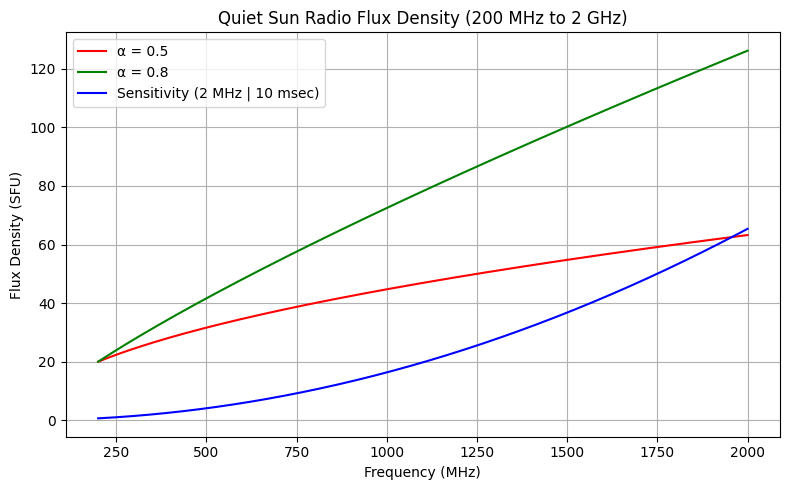

In [36]:
# Frequency range: 200 MHz to 2 GHz
freq = np.linspace(200e6, 2e9, 500)  # Hz
l_arr = sc.speed_of_light/freq

# Assume a power-law: S_nu ∝ nu^α
alpha1 = 0.5  # typical spectral index for quiet Sun in this range
alpha2 = 0.8
S_200MHz = 20  # SFU at 200 MHz (approximate reference value)

# Calculate flux density at all frequencies
flux_density_1 = S_200MHz * (freq / 200e6) ** alpha1  # in SFU
flux_density_2 = S_200MHz * (freq / 200e6) ** alpha2  # in SFU

# Sensitvity calculation
Aeff_arr = get_Aeff(l_arr,gain,N,1)
sefd_arr,senstivity_arr = get_sensitivity(T,Aeff_arr, bandwidth,tau)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(freq / 1e6, flux_density_1, label=f"α = {alpha1}", color='red')
plt.plot(freq / 1e6, flux_density_2, label=f"α = {alpha2}", color='green')
plt.plot(freq / 1e6, senstivity_arr, label="Sensitivity (2 MHz | 10 msec)", color='blue')
plt.xlabel("Frequency (MHz)")
plt.ylabel("Flux Density (SFU)")
plt.title("Quiet Sun Radio Flux Density (200 MHz to 2 GHz)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Old Calculations

In [121]:
# Define Parameters

chan_width = 10 # kHz
start_nu = 400 # MHz
end_nu = 1600 # MHz
num_chan = int((end_nu-start_nu)/chan_width*1000)
nu_array=np.linspace(start_nu,end_nu,num_chan)

obs_nu = 800 # MHz
D = 2 # Meters
lam = 3.e8/800.e6
theta = lam / D # rad
theta_deg = theta * 180/np.pi 

print(lam, 'm', theta_deg, 'deg')

0.375 m 10.742958658702936 deg


In [128]:
D_array = np.linspace(0.5,25,200)
nu_array = 300/lam_array
lam_array = np.linspace(0.2,1,100)
lamd_array = np.meshgrid(D_array, lam_array)
theta_array = lamd_array[1]/lamd_array[0]
theta_deg_array = theta_array * 180/np.pi 
print(nu_array.shape,D_array.shape)

(100,) (200,)


[89]


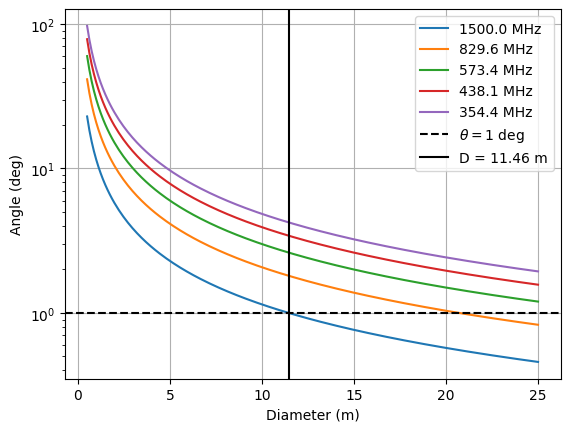

In [129]:
D_idx=np.where(abs(theta_deg_array[0]-1)==np.min(abs(theta_deg_array[0]-1)))[0]
print(D_idx)
for i in range(5):
    plt.plot(D_array, theta_deg_array[20*i],label=str(np.round(nu_array[20*i],1))+' MHz')
plt.xlabel('Diameter (m)')
plt.ylabel('Angle (deg)')
# plt.xscale('log')
plt.yscale('log')
plt.axhline(y=1,linestyle='--',color='k',label='$\\theta=$1 deg')
plt.axvline(x=D_array[D_idx],color='k',label='D = '+str(np.round(D_array[D_idx][0],2))+' m')
plt.legend()
plt.grid()

In [186]:
"""
Calculation given a sentitvity level compute the antenna surface area

"""

min_S = 1.e4 # 0.1 SFU 
Tsys = 350 # in K
sigma_dec =5
tau=0.001 # in sec
BW = 10.e3 # 10 kHz
del_Srms = min_S/sigma_dec
tauBW = np.sqrt(tau*BW)
print('sqrt(tau*BW) =',tauBW)
A = 2*1380*Tsys/del_Srms/tauBW # in sq. mts
SEFD = 2*1380/A # in Jy
dish_diameter = np.sqrt(4*A/np.pi)
print('Area:',A,'sq. m ','SEFD:',SEFD,' Jy')
print('Dish diameter:', dish_diameter)

lf=400 # lower end frequency (MHz)
hf=1600 # high end frequency
lang = (3.e2/lf)/dish_diameter*180/np.pi
hang = (3.e2/hf)/dish_diameter*180/np.pi
print('Angle range',hang,' to ',lang)

nchan = (hf-lf)*1.e6/BW # number of channels for 400 MHz to 1600 MHz
nbytes = 2
data_rate = nchan*nbytes/tau
print('Data Rates:',data_rate/1.e6,'Mbytes s$^{-1}$ ','nchan:',nchan)

selfnoise = min_S / (np.sqrt(1)*tauBW)
print('Self-Noise:', selfnoise/1.e4, 'SFU',' factor:',tauBW)


sqrt(tau*BW) = 10.0
Area: 48.3 sq. m  SEFD: 57.142857142857146  Jy
Dish diameter: 7.842032262794406
Angle range 1.369920232242812  to  5.479680928971248
Data Rates: 24.0 Mbytes s$^{-1}$  nchan: 12000.0
Self-Noise: 0.1 SFU  factor: 10.0


Self Noise (SFU) 0.2238305162394082


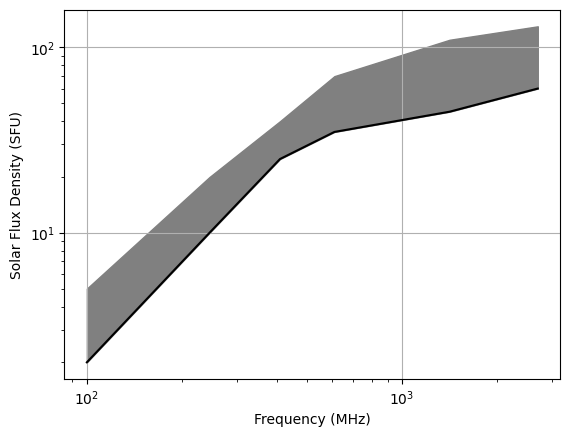

In [370]:
# Self noise calculation

def self_noise(n,BW,tau,S,SEFD):
    nb=n*(n-1)/2
    S1=S/(S+SEFD)
    return (S+SEFD)*np.sqrt(1+2*(n-2)*S1+(1+(n-1)*(n-2))*S1*S1)/np.sqrt(2*nb*BW*tau)

BW = 1.e4 # 10 kHz
tau = 1.e-3 # 1 ms
S = 1.e-3 # in SFU
SEFD = 1 # in SFU
n=2
S_self_noise = self_noise(n,BW,tau,S,SEFD)
print('Self Noise (SFU)',S_self_noise)

freq = np.array([100,245,410,610,1415,2695])
qs_flux_min = np.array([2,10,25,35,45,60])
qs_flux_max = np.array([5,20,40,70,110,130])

sn_qs_flux_min = qs_flux_min/tauBW
sn_qs_flux_max = qs_flux_max/tauBW

f,ax = plt.subplots(1,1)
ax.plot(freq,qs_flux_min,color='k')
ax.set_ylabel('Solar Flux Density (SFU)')
ax.set_xlabel('Frequency (MHz)')
ax.fill_between(freq,qs_flux_min,qs_flux_max,color='gray')
#ax.fill_between(freq,sn_qs_flux_min,sn_qs_flux_max,color='red')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid()
plt.show()



In [220]:
ndish = 10
dish_diameter = 10 # in mts
A = ndish*np.pi*dish_diameter**2 /4.0
Tsys = 350 # in K
SEFD = 2*1380*Tsys/A/1.e4
print('SEFD: ',SEFD, 'SFU', )

#self noise ns = S / \sqrt(B*t)
tau=0.001
snr = 5
B = SEFD**2 / ((sn_qs_flux_min/snr)**2 * tau)
print(B.max())
f,ax=plt.subplots(1,1)
ax.plot(freq,B/1000.,'o-')
ax.set_yscale('log')
ax.grid()
plt.show()

SEFD:  0.12299494002141673 SFU
9454.847044294935


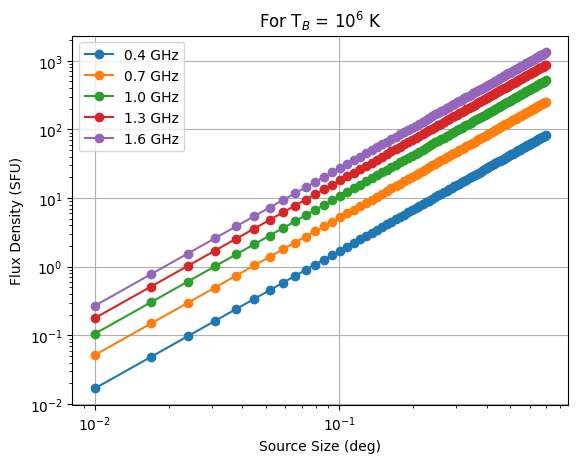

In [232]:
# Flux density as a function of angular scales
# Show a taper at 0.7 (~40' disk size) 
TB = 1.e6
ang = np.linspace(0.01,0.7,100)*3600
nu0 = np.linspace(0.4,1.6,5)
FD = [0]*100
for i in range(len(nu0)):
    FD[i] = TB*nu0[i]**2 *ang**2 /1222 /1.e4 /1.e3
    plt.plot(ang/3600,FD[i],'o-',label=str(np.round(nu0[i],1))+' GHz')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Source Size (deg)')
plt.ylabel('Flux Density (SFU)' )
plt.title('For T$_B$ = 10$^6$ K')
plt.show()

SS: [7.4799727  2.32983488 1.6679396  1.46639707 1.33118599 1.30883044] 110
######## Instrument 1
3.1622776601683795
Rsample: [1.37924577e+10 1.26096847e+08 1.24615193e+06 1.24165778e+04
 1.23864730e+02 1.23814990e+00]
T_ant [   294.01194112   1764.80667656   4942.3407302   10940.18432902
  58867.80588062 213541.60786428]
nb: [5.10831768e+10 4.67025361e+08 4.61537751e+06 4.59873253e+04
 4.58758258e+02 4.58574037e+00]
nant: [3.19635219e+05 3.05627434e+04 3.03871580e+03 3.03773640e+02
 3.07946615e+01 3.56944307e+00]
SEFD: 111.46639707080861 Aeff: 19.10295956178441 Aeff_op [70846.69210761 16810.45883326  4414.37714932   963.70519172
   514.59567324   186.45575323]
######## Instrument 2
89.44271909999159
Rsample: [8.16558014e+03 7.46534035e+01 7.37762162e-01 7.35101483e-03
 3.37500000e-04 3.37500000e-04]
T_ant [   294.01194112   1764.80667656   4942.3407302   10940.18432902
  58867.80588062 213541.60786428]
nb: [2.41943115e+07 2.21195270e+05 2.18596196e+03 2.17807847e+01
 1.00000000e+00 1.

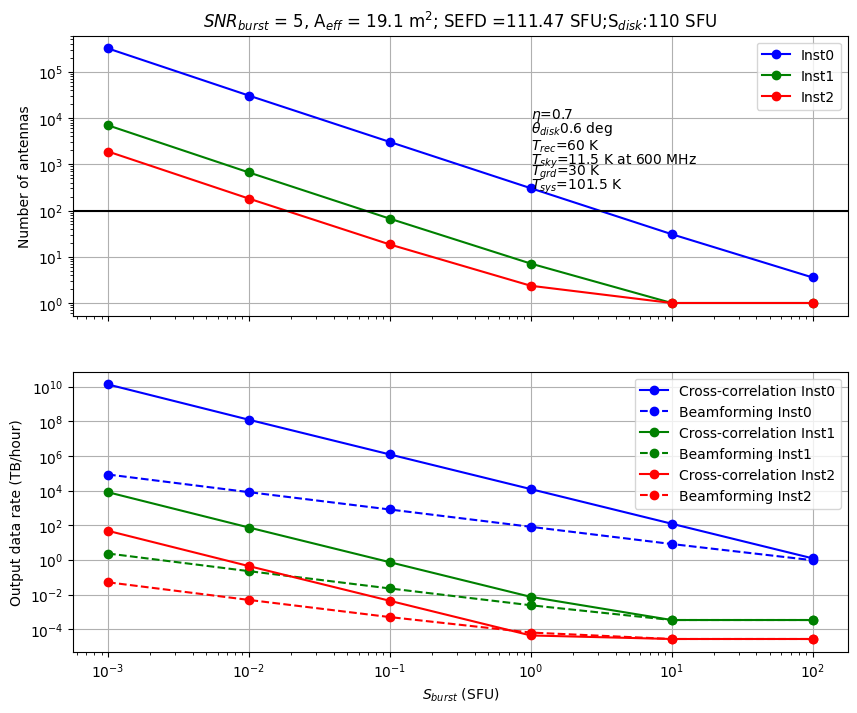

In [104]:
freq = np.array([100,245,410,610,1415,2695])
qs_flux_min = np.array([2,10,25,35,45,60])
qs_flux_max = np.array([5,20,40,70,110,130])
S_burst_array = np.array([0.001,0.01,0.1,1.0,10.0,100.0])
Trec = 60
Tground = 30
Tsky = 40*(327/freq)**2
Tsys = Trec + Tground + Tsky 

inst = {'inst1':{'BW':10.e3,'tau':1.e-3},
        'inst2':{'BW':400.e3,'tau':20.e-3},
        'inst3':{'BW':2000.e3,'tau':50.e-3}
        }
size_disk=0.6 # deg
S_burst=S_burst_array # in SFU
S_disk=qs_flux_max[4]
sigma_noise = S_burst / 5.0
alpha=1
beta = 2.7 # times the solar disk, the primary beam; 2.7 for 6 m disk, 2 for 8 m disk
fh=1800 # highest frequency 1800 MHz
lh = 300.0/fh
D = lh/(beta*size_disk*np.pi/180)
eta = 0.7
Aeff= eta*np.pi*D**2 /4.0 
SEFD_ = 2*1380*Tsys/Aeff*1.e-4 + alpha*S_disk
print('SS:',2*1380*Tsys/Aeff*1.e-4, alpha*S_disk)
SEFD = SEFD_
total_BW=300.e6 # in MHz
npol = 2
nbit = 10
BWtau = [0]*3; nb = [0]*3; nant = [0]*3; nchan = [0]*3; Rsample = [0]*3; Rsample_ant = [0]*3
Aeff_op = [0]*3
c=['b','g','r']
for i in range(3):
    print('######## Instrument '+str(i+1))
    nchan[i] = total_BW/inst['inst'+str(i+1)]['BW']
    BWtau[i]=np.sqrt(inst['inst'+str(i+1)]['BW']*inst['inst'+str(i+1)]['tau'])
    print(BWtau[i])
    nb[i] = 0.5* (SEFD / (sigma_noise*BWtau[i]-S_burst))**2
    nant[i] = 0.5*(1+np.sqrt(1+8*nb[i]))
    for j in range(len(nb[i])):
        if(nb[i][j]<1):
            nb[i][j]=1
            nant[i][j]=1
    Rsample[i] = nchan[i]*npol*nbit/inst['inst'+str(i+1)]['tau']*nb[i]/8/1.e12*3600
    print('Rsample:',Rsample[i])
    Rsample_ant[i] = nchan[i]*npol*nbit/inst['inst'+str(i+1)]['tau']*nant[i]/8/1.e12*3600
    #T_ant=1.e6*(20*20/((300/freq)/D*180/np.pi*3600)**2)
    T_ant=1.e6*(0.5*0.5*3600*3600/((300/freq)/D*180/np.pi*3600)**2)
    print('T_ant',T_ant)
    Aeff_op[i] = 2*1.38e-23*(Tsys+T_ant)/(S_burst*1.e-22*BWtau[i])
    #print('Rsample_ant:',Rsample_ant[i])
    print('nb:',nb[i])
    print('nant:',nant[i])
    print('SEFD:',SEFD[3], 'Aeff:',Aeff,'Aeff_op',Aeff_op[i])

print('Diameter:',D,' m; SEFD:',SEFD,' SFU; ','S-disk:',S_disk,'SFU')
print('sigma_noise',sigma_noise,' SFU')
f,(ax0,ax1)=plt.subplots(2,1,sharex=True,figsize=(10,8))
for i in range(3):
    ax0.plot(S_burst_array,nant[i],'o-',color=c[i],label = 'Inst'+str(i))
#ax1=ax.twiny()
ax1.set_xlabel('$S_{burst}$ (SFU)')
ax0.set_ylabel('Number of antennas')
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.legend()
ax0.grid()
ax0.set_title('$SNR_{burst}$ = 5'+', A$_{eff}$ = '+str(np.round(Aeff,1))+
             ' m$^2$; SEFD ='+str(np.round(SEFD[3],2))+' SFU;'+'S$_{disk}$:'+
             str(np.round(S_disk,2))+' SFU')
ax0.text(1,10000,'$\\eta$='+str(eta))
ax0.text(1,5000,'$\\theta_{disk}$'+str(size_disk)+' deg')
ax0.text(1,2000,'$T_{rec}$='+str(Trec)+' K')
ax0.text(1,1000,'$T_{sky}$='+str(np.round(Tsky[3],1))+' K at 600 MHz')
ax0.text(1,600,'$T_{grd}$='+str(np.round(Tground,1))+' K')
ax0.text(1,300,'$T_{sys}$='+str(np.round(Tsys[3],1))+' K')
#ax.text(1,400,'$R_{rec}$='+str(np.round(Rsample,2))+' s$^$')
for i in range(3):
    ax1.plot(S_burst_array,Rsample[i],'o-',color=c[i],label = 'Cross-correlation Inst'+str(i))
    ax1.plot(S_burst_array,Rsample_ant[i],'o--',color=c[i],label = 'Beamforming Inst'+str(i))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Output data rate (TB/hour)')
ax1.legend()
ax1.grid()
ax0.axhline(y=100,color='k')
plt.show()

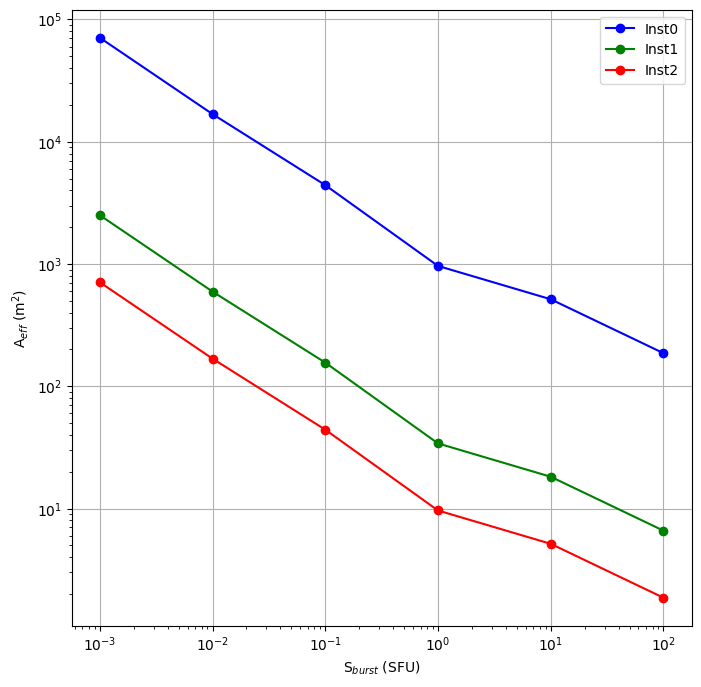

In [105]:

f,ax1=plt.subplots(1,1,sharex=True,figsize=(8,8))
for i in range(3):
    ax1.plot(S_burst_array,Aeff_op[i],'o-',color=c[i],label = 'Inst'+str(i))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel( 'A$_{eff}$ (m$^{2}$)')
ax1.set_xlabel('S$_{burst}$ (SFU)')
ax1.legend()
ax1.grid()
ax0.axhline(y=100,color='k')
plt.show()

In [89]:
# S = 2kTb / lambda^2 /omega
# Tb = S \lambda^2 omega /2k

minS = 10.e-3 # SFU
mint = 20.e-3 # 1 ms
theta = 20 # in arcsec
fl=400
ll=300/fl
fh=1800
lh=300/fh
Tb = 1222*minS*1.e4*1.e3/(fl*fl*1.e-6*theta**2)
print(Tb)

Sdisk = 110
theta_disk = 0.6*3600
Tb_disk = 1222*Sdisk*1.e4*1.e3/(fl*fl*1.e-6*theta_disk**2)
print(Tb_disk)

fl=400
ll=300/fl
fh=1800
lh=300/fh
D1 = ll/(0.5*np.pi/180)
D2 = ll/(20.0/3600*np.pi/180)
print(D1, D2)

ratio_sdisk_sburst = 0.6*0.6*3600*3600/(20*20)
print(ratio_sdisk_sburst)


1909375.0
1800679.4410150892
85.94366926962348 7734.930234266114
11664.0
